# 3. Clasificación (Naive Bayes Multinomial)

**Alumnos**

- Aguilera Luzania José Luis
- Francisco Javier Castro Marquez

## Contenido
---

**Introducción**
- Clasificación de texto
- Objetivo de la libreta.

**Procesamiento de los datos**
- Librerías
- Cargar el *corpus*
- Datos necesarios: *Text* y *Category*
- Palabras vacías o *stopwords*
- Cargar el lematizador
- Procesamiento del texto
- Vectorización y características TFIDF
- Separación de los conjuntos de datos

**Métricas**
- Matriz de confusión

**Naive Bayes Multinomial**
- Modelo
- Resultados

## Introducción
---

#### Clasificación de texto

La clasificación de textos es la tarea de clasificar un documento en una categoría predefinida, es decir, si *d_j* es un documento del conjunto de documentos *D* y *{c_1, c_2, ..., c_n}* es el conjunto de categorías, entonces la clasificación de textos asigna una categoría *c_i* al documento *d_j*. El caso de la detección de noticias falsas se puede resolver como un problema de clasificación de textos, donde a cada noticia *n_i* del conjunto de noticias *N* le asignamos una categoría del conjunto *{true, fake}*.

El proceso de clasificación de textos se muestra en la siguiente figura:


<p align="center">
<img src="./Imagenes/proceso_clasificacion_textos.png" width="500">
</p>

#### Objetivo de la libreta

El objetivo de esta libreta es mostrar el procesamiento necesario del texto para después ser usado en un clasificador de texto y utilizar distintos métodos para clasificar el texto.

## MLflow Setup
---

In [1]:
import mlflow

# Traking ═══════════════════════════════════════════════════
track_uri = "http://localhost:5000"
mlflow.set_tracking_uri(track_uri)

# Generación del experimento ════════════════════════════════
experiment_name = "Naive Bayes"
mlflow.set_experiment(experiment_name)

# Cargando la información ═══════════════════════════════════
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Imprimir la información ═══════════════════════════════════
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 1.26.0
Tracking URI: http://localhost:5000
Nombre del experimento: Naive Bayes
ID del experimento: 2


## Procesamiento de los datos
---

#### Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import spacy_spanish_lemmatizer
import pathlib
import pickle

from nltk.corpus import stopwords

from tqdm.notebook import tqdm_notebook

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

#### Datos adicionales para la librería `nltk`

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Cargar el corpus

In [4]:
corpus = pd.read_csv('Datos/corpus_spanish_v3.csv', encoding='utf-8', index_col=0)
corpus.head()

,Category,Topic,Source,Headline,Text,Link
0,True,Science,El país,La NASA recupera el contacto con un satélite d...,La NASA recupera el contacto con un satélite d...,https://elpais.com/elpais/2018/02/01/ciencia/1...
1,True,Economy,El financiero,AMLO aceleraría el consumo y el crecimiento ec...,AMLO aceleraría el consumo y el crecimiento ec...,http://www.elfinanciero.com.mx/economia/amlo-a...
2,Fake,Sport,actualidadpanamericana.com,Compañero de James se ‘calvea’ y le juega pesa...,Al borde de un colapso nervioso quedó el hábil...,http://www.actualidadpanamericana.com/companer...
3,Fake,Politics,actualidadpanamericana.com,Dian gravará este año a los niños que recojan ...,"Mediante pupitrazo de último minuto anoche, el...",http://www.actualidadpanamericana.com/dian-gra...
4,Fake,Politics,actualidadpanamericana.com,Uribe asegura que insultó 358 guerrilleros,Muy temprano esta mañana el expresidente y aho...,http://www.actualidadpanamericana.com/uribe-as...


#### Palabras vacías o *stopwords*

Las *stopwords* o palabras vacías son aquellas que carecen de sentido de manera individual o sin una palabra clave o *keyword*. Se utilizan las *stopwords* proporcionadas por la librería `nltk` en conjunto con las obtenidas del repositorio "stopwords-es" del usuario [genediazjr](https://github.com/stopwords-iso/stopwords-es).

*Nota: Algunos documentos utilizan palabras o referencias en inglés, por lo que se anexarán las stopwords en inglés de la librería `nltk`*.

In [5]:
stopwords_spanish_nltk = stopwords.words('spanish')
stopwords_english_nltk = stopwords.words('english')
stopwords_spanish_json = list(pd.read_json('Datos/stopwords-es.json')[0])

stopwords_spanish = list(set(stopwords_spanish_nltk +
                             stopwords_english_nltk +
                             stopwords_spanish_json))

print(f'Stopwords count: {len(stopwords_spanish)}')

Stopwords count: 906


#### Cargar el lematizador

La lematización consisten en que dada una forma flexionada (plural, femenino, conjugada, etc.) se halla el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Por ejemplo: el lema de *"diré"*, *"dije"* y *"diríamos"* es *"decir"*. Utilizar los lemas permite conservar coherencia en el texto, mientras que se reduce su tamaño.

Para poder lematizar palabras en español se utiliza la librería `spacy` en conjunto con las reglas para lematización en español creadas por el usuario de github [pablodms](https://github.com/pablodms/spacy-spanish-lemmatizer).

Para poder utilizar el lematizador es necesario ejecutar los siguientes comandos en la consola o en una celda de jupyter.

```powershell
pip install -U pip setuptools wheel
python -m spacy download es_core_news_sm
python -m spacy download es_core_news_lg
python -m spacy_spanish_lemmatizer download wiki
```

In [6]:
spacy.require_gpu()
nlp = spacy.load('es_core_news_lg')
nlp.replace_pipe('lemmatizer', 'spanish_lemmatizer')

#### Procesamiento del texto

En el procesamiento requiere de dos funciones `process_text` y `get_processed_corpus`.

**Función: process_text**

Se encarga de procesar el texto realizando los siguientes pasos:
- Eliminar hipervínculos.
- Eliminar los saltos de línea.
- Cambiar las etiquetas de números, teléfonos, correos y urls por una en español.
- Eliminar todos los caracteres que no sean del español.
- Obtener los lemas de todas las palabras del texto.

**Función: get_processed_corpus**

Procesar las más de 3000 noticias que hay en el corpus no es una tarea que lleva su tiempo, para reducir el tiempo en el que se ejecuta la libreta y se realizan pruebas en los modelos se creo la función `get_processed_corpus` que procesar el corpus y guardarlo en un archivo para cargarlo después de modo que solo se procesa una vez y se puede utilizar cada vez que sea necesesario, en caso de querer procesarlo cada vez que se ejecute, solo es necesario eliminar el archivo `processed_corpus_spanish.csv`.

In [7]:
def process_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
    text = re.sub("\n", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    text = re.sub('[^ A-Za-z\dÁÉÍÓÚÑáéíóúñ/]+', ' ', text)
    text = [token.lemma_ for token in nlp(text)
            if token.is_alpha and
            not token.lemma_ in stopwords_spanish]
    text = ' '.join(text)

    return text


def get_processed_corpus():
    processed_corpus_file = pathlib.Path('Datos/processed_corpus_spanish.csv')
    if processed_corpus_file.is_file():
        df = pd.read_csv(processed_corpus_file, encoding='utf-8')
    else:
        # Procesar el texto.
        tqdm_notebook.pandas(desc="Procesando el texto")
        text_to_process = corpus['Text']
        text_to_process = text_to_process.progress_apply(process_text)

        # Procesar las etiquetas.
        text_labels = corpus['Category']
        text_labels = text_labels.astype('category').cat.codes

        # Guardar los datos procesados.
        df = pd.concat([text_to_process, text_labels], axis=1)
        df.columns = ['Text','Category']
        df.to_csv(processed_corpus_file, encoding='utf-8', index=False)

    return df['Text'], df['Category']

In [8]:
# Datos necesarios ══════════════════════════════════════════
X, y = get_processed_corpus()

# Numpy ═════════════════════════════════════════════════════
X = X.values
y = y.values

In [9]:
# MLFlow ════════════════════════════════════════════════════
mlflow.sklearn.autolog()

#### Vectorización y características TF-IDF

**Vectorización**

Consiste en convertir las palabras en los textos de las noticias en vectores numéricos que las representan.

**Term frequency - Inverse document frequency**

- Es una técnica que expresa que tan relevante es una palabra para un documento (texto).
- TF-IDF es el producto de dos medidas
    - **Term Frequency:** Mide el número de veces que un término (palabra) aparece en el documento.
    - **Inverse Document Frequency:** Mide si el término es común o no, en el documento.

**TF-IDF Vectorizer**

- Convierte una colección de documentos en una matriz de características TF-IDF, donde las columnas son los documentos y los renglones los términos, los valores de cada elemento son la importancia en dicho documento.
- Es el equivalente a utilizar CountVectorizer seguido de TfidfTransformer.
    - **CountVectorizer:** Convierte una colección de documentos en una matriz de conteo de tokens.
    - **TfidfTransformer:** Convierte una matriz de conteo en una matriz de características TF-IDF.


In [10]:
# Características ═══════════════════════════════════════════
max_features = 30000
ngram_range = (1,3)

# Guardar características y ngramas ═════════════════════════
mlflow.log_params({
    'max_features': str(max_features),
    'ngram_range': f'{ngram_range}'
})

# Vectorización y extracción de características ═════════════
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, lowercase=False, strip_accents='unicode')
X = tfidf_vectorizer.fit_transform(X).toarray()

tfidf_vectorizer_path = 'Archivos_pkl/tfidf_vectorizer.pk'
with open(tfidf_vectorizer_path, 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

mlflow.log_artifact(tfidf_vectorizer_path, 'TFIDF_Vectorizer')

#### Separación de los conjuntos de datos

In [11]:
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2021)

# Guardar el tamaño del conjunto de entrenamiento ═══════════
mlflow.log_param('test_size', str(test_size))

## Métricas
---

#### Matriz de confusión

Es una representación matricial de la predicción de los resultados, usualmente usada para describir el rendimiento de clasificación de un modelo en el conjunto de pruebas para los cuales el resultado es conocido.

- True Positives: Casos en los que predecimos SI y el valor real es SI.
- True Negatives: Casos en los que predecimos NO y el valor real es SI.
- False Positives: Casos en los que predecimos SI y el valor real es NO.
- False Negatives: Casos en los que predecimos NO y el valor real es SI.

In [12]:
def plot_confusion_matrix(y_test_values, y_predicted_values, method=''):
    cf_matrix = confusion_matrix(y_test_values, y_predicted_values)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize = (7, 5.5))
    sns.heatmap(cf_matrix, annot = labels, ax = ax, fmt = '',cmap = 'Blues', annot_kws = {"size": 13})

    # Etiquetas, título y ticks
    label_font = {'size':'15'}
    ax.set_xlabel(' \nPredicción', fontdict = label_font)
    ax.set_ylabel('Valores reales\n', fontdict = label_font)

    title_font = {'size':'16'}
    cf_matrix_title = 'Matriz de confusión: ' + method + '\n'
    ax.set_title(cf_matrix_title, fontdict = title_font)

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax.xaxis.set_ticklabels(['Fake', 'Real'])
    ax.yaxis.set_ticklabels(['Fake', 'Real'])

    # Guardar el archivo.
    plt.savefig(f'Plots/artifacts/matriz_confusion_{method}.png')
    mlflow.log_artifact(f'Plots/artifacts/matriz_confusion_{method}.png')

    plt.show()

## Naive Bayes Multinomial
---


#### Introducción

Naive Bayes es uno de los modelos más simples y usados en clasificación de texto porque sus resultados son tan buenos como otros modelos más sofisticados.

Se basa en la aplicación del teorema de Bayes para predecir la probabilidad de que un documento pertenezca a una clase *P(c_i|d_j)* a partir de la probabilidad de los documentos dada la clase *P(d_j|c_i)* y la probabilidad a priori de la clase en el conjunto de entrenamiento *P(c_i)*.

<br>
<p align="center">
<img src="./Imagenes/info/naive_bayes_eq.png" width="300">
</p>

MultinomialNB implementa el algoritmo de Naive Bayes para datos distribuidos multinomialmente, y es una de las dos variantes clásicas de Naive Bayes  utilizadas en la clasificación de textos (donde los datos se representan normalmente como recuentos de vectores de palabras, aunque también se sabe que los vectores tf-idf funcionan bien en la práctica). La distribución está parametrizada por vectores *theta_y = (theta_y_1, ..., theta_y_n)* para cada clase *y*, donde *n* es el número de características (en la clasificación de textos, el tamaño del vocabulario) y *theta_y_i* es la probabilidad *P(x_i | y)* de que el rasgo *i* aparezca en una muestra perteneciente a la clase *y*.

Los parámetros *theta_y* se estiman mediante una versión suavizada de máxima verosimilitud, es decir, el recuento de la frecuencia relativa:

<br>
<p align="center">
<img src="./Imagenes/info/naive_bayes_frequency_counting.png" width="150">
</p>

donde

<br>
<p align="center">
<img src="./Imagenes/info/naive_bayes_number_of_times_feature.png" width="150">
</p>

es el número de veces que la característica *i* aparece en una muestra de la clase *y* en el conjunto de entrenamiento *T*, y

<br>
<p align="center">
<img src="./Imagenes/info/naive_bayes_count_of_all_features.png" width="150">
</p>

es el recuento total de todas las características para la clase *y*.

Los priores de suavizado *alpha >= 0* tienen en cuenta las características que no están presentes en las muestras de aprendizaje y evitan las probabilidades nulas en los cálculos posteriores. Establecer *alpha = 1* se llama suavizado de Laplace, mientras que *alpha < 1* se llama suavizado de Lidstone.

2022/05/18 01:26:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "D:\Github\Deteccion-de-Noticias-Falsas\Notebooks\virtualenv\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


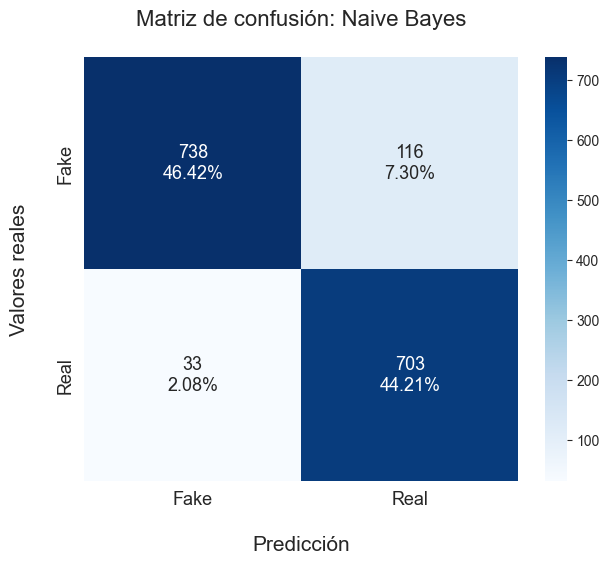

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       771
           1       0.96      0.86      0.90       819

    accuracy                           0.91      1590
   macro avg       0.91      0.91      0.91      1590
weighted avg       0.91      0.91      0.91      1590



In [13]:
# Modelo ════════════════════════════════════════════════════
alpha = 0.5
fit_prior = True

model_NB = MultinomialNB(alpha=alpha)
model_NB.fit(X_train, y_train)

mlflow.log_params({
    'alpha': str(alpha),
    'fit_prior': str(fit_prior)
})

# Predicción ════════════════════════════════════════════════
y_predicted_NB = model_NB.predict(X_test)

# Resultados ════════════════════════════════════════════════
# Matriz de confusión
plot_confusion_matrix(y_predicted_NB, y_test, 'Naive Bayes')

# Reporte de clasificación
print(classification_report(y_test, y_predicted_NB))

# Accuracy-score
accuracy_score_metric = accuracy_score(y_test, y_predicted_NB, normalize=True)

# Loss and Accuracy
f1_score_metric = f1_score(y_test, y_predicted_NB)

mlflow.log_metrics({
    'F1 Score': f1_score_metric,
    'Accuracy-Score': accuracy_score_metric
})

In [14]:
# Imprimiendo donde se encuentra la información
run_id = mlflow.last_active_run().info.run_id
print(f"Datos y modelo en la corrida: {run_id}")

# Terminar run.
mlflow.end_run()

Datos y modelo en la corrida: 1d80532bf3a64b969e1f4f02ae4e5db1
